In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
import plotly.express as px
import plotly.graph_objects as go
import dash_bootstrap_components as dbc
from dash import html,dcc,Input,Output,Dash,dash_table
from jupyter_dash import JupyterDash
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,multilabel_confusion_matrix,mean_squared_error
from xgboost import XGBRegressor,plot_importance,XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,GradientBoostingClassifier,RandomForestClassifier
px.set_mapbox_access_token(open("./dataset/mapbox_token.txt").read())

## 功能
用房型區分<br>
用城市當作過濾條件<br>
用社區當作過濾條件<br>
## code
callback分開寫<br>
graph(*2)、過濾後的文字(*2)<br>

## css
底色調黑

In [3]:
df = pd.read_csv('./dataset/AB_NYC_2019.csv',parse_dates=['last_review'])
df.drop(['id','host_id','host_name'],axis=1,inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38837 entries, 0 to 48852
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            38837 non-null  object        
 1   neighbourhood_group             38837 non-null  object        
 2   neighbourhood                   38837 non-null  object        
 3   latitude                        38837 non-null  float64       
 4   longitude                       38837 non-null  float64       
 5   room_type                       38837 non-null  object        
 6   price                           38837 non-null  int64         
 7   minimum_nights                  38837 non-null  int64         
 8   number_of_reviews               38837 non-null  int64         
 9   last_review                     38837 non-null  datetime64[ns]
 10  reviews_per_month               38837 non-null  float64       
 11  ca

In [4]:
external_stylesheets=[dbc.themes.BOOTSTRAP]
app = JupyterDash(__name__,external_stylesheets=external_stylesheets)

app.layout = dbc.Container(
    [
        # Data Display Panel
        dbc.Row(
            [
                # Left
                dbc.Col(
                    [   
                        html.Br(),
                        # dbc.Row(
                        #     dcc.DatePickerSingle(
                        #         id='select_review_date',
                        #         min_date_allowed=date(2011,3,28),
                        #         max_date_allowed=date(2019,7,8),
                        #         initial_visible_month=date(2018,11,26),
                        #         date=date(2018,11,26),
                        #         style={'width': '100%'}
                        #     ),
                        #  ),
                        html.Br(),
                        dbc.Row(
                            'Select the price range:',
                            style={'color':'white'}
                        ),
                        dbc.Row(
                            dcc.Dropdown(
                                id='select_price_range',
                                options=[
                                            {'label': '> $50', 'value': 50},
                                            {'label': '$50 < $100', 'value': 100},
                                            {'label': '$100 < $150', 'value': 150},
                                            {'label': '$150 >', 'value': 150}
                                        ],
                                value=100
                            )
                        ),
                        html.Br(),
                        dbc.Row(
                            'Select the neighbourhood:',
                            style={'color':'white'}
                        ),
                        dbc.Row(
                            dcc.Dropdown(
                                id='select_neighbourhood_group',
                                options=df.neighbourhood_group.unique(),
                                multi=True
                            )
                        ),
                        html.Div(
                            [
                                html.P('Total number of avaliable house: ',
                                       style={'display':'inline-block','color':'white'}),
                                html.Div(id='total_house',
                                         style={'display':'inline-block','color':'white'}),
                                html.P('Showing neighbourhood:',
                                       style={'display':'inline-block','color':'white'}),
                                html.Div(id='neighbourhood',
                                         style={'display':'inline-block','color':'white'}),
                            ]
                        )
                    ],
                style={'backgroundColor':'#1A4999'}
                
                ),
                # Right
                dbc.Col(
                    [
                        # Top
                        dbc.Row(
                            dcc.Graph(id='map')
                        ),
                        # Bottom
                        dbc.Row(
                            dbc.Col(dcc.Graph(id='bar'),md=6)
                        ),
                    ],
                    width=9,
                ),
            ]
        )
    ],
    fluid=True,
    style={"height": "100vh"},
)

@app.callback(
    Output('total_house','children'),
    Input('select_neighbourhood_group','value')
)

def render_house_numer(selected_val):
    if selected_val == None:
        pass
    elif selected_val:
        count = 0
        for i in range(len(selected_val)):
            mask = df['neighbourhood_group'] == selected_val[i]
            new_count = len(df[mask])
            count += new_count
        return count


@app.callback(
    Output('neighbourhood','children'),
    Input('select_neighbourhood_group','value')
)

def render_neighbourhood_text(selected_val):
    if selected_val == None:
        pass
    elif len(selected_val) == 1:
        return selected_val
    elif len(selected_val)>1:
        selected_val = list(selected_val)
        selected_val = ','.join(selected_val)
        return selected_val

@app.callback(
    Output('map','figure'),
    Input('select_neighbourhood_group','value')
)    

def render_map(neighbourhood):
    if neighbourhood:
        mask = (df['neighbourhood_group'] == neighbourhood[0])
        fig = px.scatter_mapbox(
                df[mask], 
                lat="latitude", lon="longitude", 
                color="room_type", 
                size="price",
                mapbox_style="carto-positron"
        )
        fig.update_layout(
            paper_bgcolor='rgb(243, 243, 243)',
            plot_bgcolor='rgb(243, 243, 243)'
        )
        return fig
    elif neighbourhood == None:
        fig = go.Figure()
        fig.update_layout(paper_bgcolor='rgb(243, 243, 243)')
        fig.update_layout(plot_bgcolor='rgb(243, 243, 243)')
        return fig

@app.callback(
    Output('bar','figure'),
    Input('select_neighbourhood_group','value')
)

def render_bar(neighbourhood):
    if neighbourhood:
        mask = (df['neighbourhood_group'] == neighbourhood[0])
        val_counts_df = pd.DataFrame(df[mask]['neighbourhood'].value_counts()).reset_index()
        val_counts_df.columns = ['neighbourhood','counts']
        val_counts_df = val_counts_df.head(10)
        fig = px.bar(val_counts_df,x='neighbourhood',y='counts',color='neighbourhood')
        return fig
    elif neighbourhood == None:
        fig = go.Figure()
        fig.update_layout(paper_bgcolor='rgb(243, 243, 243)')
        fig.update_layout(plot_bgcolor='rgb(243, 243, 243)')
        return fig
    
if __name__ == '__main__':
    # 'external' or 'inline'
    app.run_server(mode="external",debug=True,port=8000)

Dash app running on http://127.0.0.1:8000/


In [74]:
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35440 entries, 0 to 48852
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   name                            35440 non-null  object        
 1   neighbourhood_group             35440 non-null  object        
 2   neighbourhood                   35440 non-null  object        
 3   latitude                        35440 non-null  float64       
 4   longitude                       35440 non-null  float64       
 5   room_type                       35440 non-null  object        
 6   price                           35440 non-null  float64       
 7   minimum_nights                  35440 non-null  float64       
 8   number_of_reviews               35440 non-null  float64       
 9   last_review                     35440 non-null  datetime64[ns]
 10  reviews_per_month               35440 non-null  float64       
 11  ca

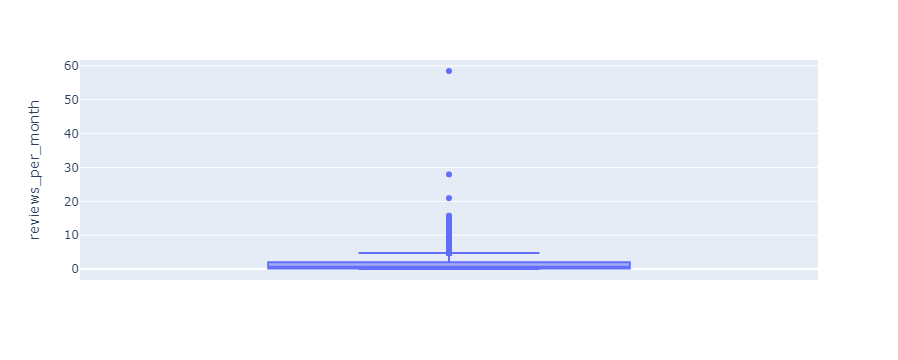

In [152]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# delete outlier
mask = (df['reviews_per_month']<(Q1 - 1.5 * IQR)) | (df['reviews_per_month']>(Q3 + 1.5 * IQR))
df[mask] = np.nan
df.dropna().info()
fig = px.box(df,y='reviews_per_month')
fig.show()

In [119]:
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', nan, 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [41]:
# mask = df['neighbourhood_group']==['Brooklyn','Manhattan']
# df[mask]
# df[df['neighbourhood_group'] == 'Brooklyn']
# count = 0
# mask = df['neighbourhood_group'] == ['Brooklyn']
# new_count = len(df[mask])
# count += new_count
# count
test = ['apple','ss','gy']
test.pop(0)
test

['ss', 'gy']

In [58]:
count = 0
selected_val = ['Brooklyn','Manhattan']
for i in range(len(selected_val)):
    mask = df['neighbourhood_group'] == selected_val[i]
    new_count = len(df[mask])
    count += new_count
    print(count)

16445
33073


In [146]:
mask = (df['neighbourhood_group'] == selected_val[0])
# px.bar(df[mask]['neighbourhood'])
df[mask]['neighbourhood'].value_counts()
x=pd.DataFrame(df[mask]['neighbourhood'].value_counts()).reset_index()
x.columns = ['neighbourhood','counts']
x

,neighbourhood,counts
0,Williamsburg,3163
1,Bedford-Stuyvesant,3141
2,Bushwick,1943
3,Crown Heights,1265
4,Greenpoint,868
5,Flatbush,497
6,Clinton Hill,480
7,Prospect-Lefferts Gardens,449
8,East Flatbush,428
9,Park Slope,410
